<a href="https://colab.research.google.com/github/AmbiTyga/73String/blob/main/Data%20Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
!pip install scrapy -q
import re
from tqdm import tqdm
import pandas as pd
import numpy as np
from w3lib.html import remove_tags
import requests
from scrapy.selector import Selector
from nltk.corpus import stopwords
STOPWORDS = stopwords.words('english')

In [37]:
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None
def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
download_file_from_google_drive('1KfiHaW7Ei31VSmi7gqfSdegTjHB8xuAm', '/content/glove.840B.300d.zip')

In [38]:
!unzip glove.840B.300d.zip

Archive:  glove.840B.300d.zip
  inflating: glove.840B.300d.txt     


# Preprocessing

In [35]:
import json, operator
def load_embed(file):
  '''
  Loads GLoVe embeddings
  file -> path to glove embeddings
  load_embed(...) -> Dict()
  '''
  def get_coefs(word,*arr): 
      return word, np.asarray(arr, dtype='float32')
  
  if file == '../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec':
      embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file) if len(o)>100)
  else:
      embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding='latin'))
      
  return embeddings_index
  
def build_vocab(texts):
  '''
  Creates a vocabulary from the given corpus
  texts -> pandas Series object
  build_vocab(...) -> Dict()
  '''
  sentences = texts.str.split().values
  vocab = {}
  for sentence in sentences:
      for word in sentence:
          try:
              vocab[word] += 1
          except KeyError:
              vocab[word] = 1
  return vocab

# Checks how many words present in embeddings wrt dataset
def check_coverage(vocab, embeddings_index):
  '''
  Checks the vocabulary from the given corpus with GLoVE data
  Returns out of vocabulary words from corpus that are not present in GLoVE data
  '''
  known_words = {}
  unknown_words = {}
  nb_known_words = 0
  nb_unknown_words = 0
  for word in vocab.keys():
      try:
          known_words[word] = embeddings_index[word]
          nb_known_words += vocab[word]
      except:
          unknown_words[word] = vocab[word]
          nb_unknown_words += vocab[word]
          pass

  print('Found embeddings for {:.3%} of vocab'.format(len(known_words) / len(vocab)))
  print('Found embeddings for  {:.3%} of all text'.format(nb_known_words / (nb_known_words + nb_unknown_words)))
  unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]
  unknown_words = pd.DataFrame(unknown_words,columns=['Word','Count'])
  return unknown_words

In [6]:
def clean(sentence):
  '''
  Removes unnecessary characters from the string
  And replaces the acronyms from business terms
  sentence -> str
  clean(...) -> str
  '''
  sentence = re.sub(r"\bcorp\b\.?",'corporation',sentence,flags = re.I)
  sentence = re.sub(r"\bltd\b\.?",'Limited',sentence,flags = re.I)
  sentence = re.sub(r"\bInc\b\.?",'incorporation',sentence,flags = re.I)
  sentence = re.sub(r"\bco\b\.?",'company',sentence,flags = re.I)
  sentence = re.sub(r"\bs\.?p\.?a\b\.?",'sales and purchase agreement',sentence,flags = re.I)
  sentence = re.sub(r"\bASA\b\.?",'Advertising and Selling Association',sentence,flags = re.I)
  sentence = re.sub(r"\bSA\b\.?",'corporation',sentence,flags = re.I)
  sentence = re.sub(r"\bPLC\b\.?",'Public Limited Company',sentence,flags = re.I)
  sentence = re.sub(r"\bAB\b\.?",'Aktiebolag',sentence,flags = re.I)
  sentence = re.sub(r"\bAG\b\.?",'Aktiengesellschaft',sentence,flags = re.I)
  sentence = re.sub(r"\be-",'electronic ',sentence,flags = re.I)
  
  
  sentence = re.sub(r'(â€™s)',"'",sentence,flags = re.I)
  sentence = re.sub(r'Â',"",sentence,flags = re.I)
  sentence = re.sub(r'\%'," percent",sentence,flags = re.I)
  sentence = re.sub(r'\#',"Number ",sentence,flags = re.I)
  sentence = re.sub(r'(a-zA-Z0-9)?(\.)(a-zA-Z0-9)?',' ',sentence,flags = re.I)
  sentence = re.sub(r'\b(\w+)( \1\b)+',r'\1', sentence)
  
  
  sentence = re.sub(r'-'," ",sentence,flags = re.I)
  sentence = re.sub(r'[,!?\'\:\(\)\/;]','',sentence)
  sentence = re.sub(r'\s+'," ",sentence)

  return sentence

  

def inc_info(keywords):
  '''
  The function googles the keywords, and returns the details from Knowledge Graph panel of Google. 
  '''
  keywords = keywords.replace(" ",'+')
  url = f'https://www.google.com/search?&q={keywords}'

  req = requests.get(url,
                   headers= {'User-agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.150 Safari/537.36'})
  details_with_tags = Selector(text = req.text).css('span.hgKElc').get()

  if not details_with_tags:
    details_with_tags = Selector(text = req.text).css('div.kno-rdesc span').get()

  if details_with_tags:
    details = remove_tags(details_with_tags)
    return details

def change_term(df):
  name,description = df['Company Name'], df['Short Description']
  desc = []
  for i,j in zip(name,description):
    if i.lower() in j.lower():
      j = re.sub(r'\b{name}\b'.format(name = i),'Company',j,flags = re.I)
      desc.append(j)
    else:
      desc.append(j)
  return desc

In [39]:
glove = load_embed("/content/glove.840B.300d.txt")

## Loading and Basic Processing

In [11]:
train = pd.read_excel("/content/Training_Data.01 (1).xlsx")
test = pd.read_excel("/content/Testing_Data_2_ (1).xlsx")
train.drop_duplicates('Business Description',inplace=True,ignore_index=True)
train['Business Description'].fillna(train[train['Business Description'].isna()]['Company Name'].apply(inc_info),inplace = True)
train.dropna(inplace = True)

train['Short Description'] = train['Business Description'].apply(clean)
train['Company Name'] = train['Company Name'].apply(clean)

test['Short Description'] = test['Business Description'].apply(clean)
test['Company Name'] = test['Company '].apply(clean)

## Train Preprocessing

In [12]:
train['Short Description'] = train['Short Description'].apply(lambda x: ' '.join([item for item in x.split() if item not in STOPWORDS]))
train['Short Description'] = change_term(train)

In [13]:
train['Short Description'] = train['Short Description'].apply(lambda x: ' '.join(["UnkW" if item not in glove else item for item in x.split()]))
train['Short Description'] = train['Short Description'].str.replace(r'\b(\w+)( \1\b)+',r'\1')
train['Short Description'] = train['Short Description'].str.replace(r'\bUnkW\b','<OOV>')
train[['Industry Classification Tag','Short Description']].to_csv('train.csv',index = False)

## Test Preprocessing

In [15]:
test['Short Description'] = test['Short Description'].apply(lambda x: ' '.join([item for item in x.split() if item not in STOPWORDS]))
test['Short Description'] = change_term(test)

In [16]:
test['Short Description'] = test['Short Description'].apply(lambda x: ' '.join(["UnkW" if item not in glove else item for item in x.split()]))
test['Short Description'] = test['Short Description'].str.replace(r'\b(\w+)( \1\b)+',r'\1')
test['Short Description'] = test['Short Description'].str.replace(r'\bUnkW\b','<OOV>')
test[['Company Name','Short Description']].to_csv('test.csv',index = False)

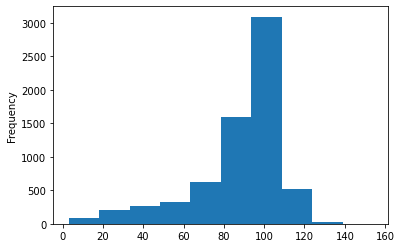

In [24]:
data['short_words_count'] = data.str.split().apply(lambda x:len(x))
data['short_words_count'].plot.hist()

# Building Vocab and embeddings

In [9]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")

In [32]:
# del data
data = pd.concat([train['Short Description'],
                  test['Short Description']],ignore_index = True)

In [40]:
vocab = build_vocab(data)
embeddings = dict()
# glove['<OOV>'] = np.random.rand(300)
for i in vocab:
  if i !="<OOV>":
    embeddings[i] = glove[i]

In [41]:
len(embeddings),len(glove)

(38838, 2196016)

# Sampling

In [11]:
train_tags = [x.sample(n=48).reset_index(drop=True) for _,x in train.groupby('Industry Classification Tag')]
train_sampled = pd.concat(train_tags,ignore_index = True)
pd.DataFrame(train_sampled['Industry Classification Tag'].value_counts())

,Industry Classification Tag
Pharmaceuticals,48
Oil & Gas Storage & Transportation,48
Technology Distributors,48
"Technology Hardware, Storage & Peripherals",48
Restaurants,48
...,...
Building Products,48
Construction Machinery & Heavy Trucks,48
Commodity Chemicals,48
Communications Equipment,48


In [12]:
train_sampled.to_csv('./sampled.csv',index = False)